In [1]:
# Load dataset (studemt Portuguese scores)
import pandas as pd
d = pd.read_csv('student-por.csv', sep=';')
len(d)

649

In [2]:
# generate binary label (pass/fail) based on G1+G2+G3 (test grades, each 0-20 pts); threshold for passing is sum>=35
d['pass'] = d.apply(lambda row: 1 if(row['G1']+row['G2']+row['G3']) >= 35 else 0, axis=1)
d = d.drop(['G1', 'G2', 'G3'], axis=1)
d.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,1


In [3]:
# use one-hot encoding on categorical columns
d = pd.get_dummies(d, columns=['sex', 'school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])
d.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


In [4]:
# shuffle rows
d = d.sample(frac = 1)
# split training and testing data
d_train = d[:500]
d_test = d[500:0]

d_train_att = d_train.drop(['pass'], axis=1)
d_train_pass = d_train['pass']

d_test_att = d_test.drop(['pass'], axis=1)
d_test_pass = d_test['pass']

d_att = d.drop(['pass'], axis=1)
d_pass = d['pass']

# number of passing estudents in whole dataset:
import numpy as np
print("Passing: %d out of %d (%.2f%%)" % (np.sum(d_pass), len(d_pass),100*float(np.sum(d_pass))/len(d_pass)))

Passing: 328 out of 649 (50.54%)


In [5]:
# fit a decision tree
from sklearn import tree
t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)
t = t.fit(d_train_att, d_train_pass)

In [6]:
# save tree
tree.export_graphviz(t, out_file="student-performance.dot", label="all", impurity=False, proportion=True,
                    feature_names=list(d_train_att), class_names=["fail", "pass"],
                    filled=True, rounded=True)

In [22]:
t.score(d_test_att, d_test_pass)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(t, d_att, d_pass, cv=5)
# show average score and +/- two standar deviations away (covering 95% of scores)
print("Accurancy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Accurancy: 0.70 (+/- 0.06)


In [14]:
for max_depth in range(1,20):
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, d_att, d_pass, cv=5)
    print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std()*2))

Max depth: 1, Accuracy: 0.62 (+/- 0.09)
Max depth: 2, Accuracy: 0.69 (+/- 0.08)
Max depth: 3, Accuracy: 0.69 (+/- 0.02)
Max depth: 4, Accuracy: 0.69 (+/- 0.05)
Max depth: 5, Accuracy: 0.70 (+/- 0.06)
Max depth: 6, Accuracy: 0.69 (+/- 0.07)
Max depth: 7, Accuracy: 0.70 (+/- 0.05)
Max depth: 8, Accuracy: 0.65 (+/- 0.08)
Max depth: 9, Accuracy: 0.67 (+/- 0.09)
Max depth: 10, Accuracy: 0.66 (+/- 0.08)
Max depth: 11, Accuracy: 0.67 (+/- 0.08)
Max depth: 12, Accuracy: 0.67 (+/- 0.09)
Max depth: 13, Accuracy: 0.67 (+/- 0.11)
Max depth: 14, Accuracy: 0.66 (+/- 0.08)
Max depth: 15, Accuracy: 0.66 (+/- 0.09)
Max depth: 16, Accuracy: 0.68 (+/- 0.07)
Max depth: 17, Accuracy: 0.64 (+/- 0.08)
Max depth: 18, Accuracy: 0.65 (+/- 0.08)
Max depth: 19, Accuracy: 0.64 (+/- 0.06)


In [18]:
depth_acc = np.empty((19,3), float)
i = 0
for max_depth in range(1,20):
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, d_att, d_pass, cv=5)
    depth_acc[i,0] = max_depth
    depth_acc[i,1] = scores.mean()
    depth_acc[i,2] = scores.std()*2
    i += 1
    
depth_acc

array([[ 1.        ,  0.61946333,  0.09489392],
       [ 2.        ,  0.6872749 ,  0.07970957],
       [ 3.        ,  0.68876565,  0.02221637],
       [ 4.        ,  0.69033989,  0.05080098],
       [ 5.        ,  0.69495528,  0.05114222],
       [ 6.        ,  0.68422182,  0.06525665],
       [ 7.        ,  0.69649374,  0.05119386],
       [ 8.        ,  0.64867024,  0.05603311],
       [ 9.        ,  0.66728682,  0.08313558],
       [10.        ,  0.6687418 ,  0.07307595],
       [11.        ,  0.66571258,  0.08637184],
       [12.        ,  0.65490757,  0.05994087],
       [13.        ,  0.66877758,  0.0656776 ],
       [14.        ,  0.66417412,  0.06652126],
       [15.        ,  0.66262373,  0.06997966],
       [16.        ,  0.66267144,  0.08361356],
       [17.        ,  0.64564103,  0.02926224],
       [18.        ,  0.6718545 ,  0.05174326],
       [19.        ,  0.65336911,  0.05193357]])

Matplotlib is building the font cache; this may take a moment.


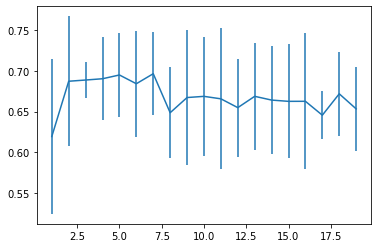

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.errorbar(depth_acc[:,0], depth_acc[:,1], yerr=depth_acc[:,2])
plt.show()